In [1]:
pip install tensorflow opencv-python scikit-learn matplotlib


**1.GEREKLİ KÜTÜPHANELERİN YÜKLENMESİ**: 

* numpy: Matematiksel işlemler ve veri manipülasyonu.opencv-python: Görüntü işleme (okuma, boyutlandırma, normalize etme vb.).

* tensorflow ve keras: CNN modelinin oluşturulması ve eğitilmesi.

* sklearn: Verilerin eğitim ve test setlerine bölünmesi, etiketlerin işlenmesi.

* matplotlib: Eğitim sonuçlarının görselleştirilmesi.
                                                  
* Aşağıdaki hücre, projede kullanılacak tüm temel kütüphaneleri içermektedir.Uyarıların kapatılması: Görünürlüğü artırmak ve çalıştırma sırasında gereksiz çıktıları engellemek için.                                          


In [2]:
import os
import numpy as np
import cv2
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Input
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
import warnings

warnings.filterwarnings("ignore")


**2. VERİ SETİNİN HAZIRLANMASI **
1. Kaynak ve hedef klasör yolları ayarlanır:
* source_dir: Orijinal veri setinin bulunduğu yer.
* target_dir: Filtrelenmiş ve işlenmiş görsellerin saklanacağı yer.

2. Her sınıftan 650 görsel seçilir:
* Sınıf adlarına göre kaynak klasörler içinde gezinilir.
* Yalnızca belirtilen sınıflardan ve belirli bir sayıda görsel alınır.
3. .Görseller yeniden kaydedilir:
* cv2.imwrite ile hedef klasöre taşınır.


In [3]:
# Veri seti klasör yolları
source_dir = "/kaggle/input/animals-with-attributes-2/Animals_with_Attributes2/JPEGImages"
target_dir = "FilteredImages"  # target_dir'in doğru tanımlandığından emin olun

# Seçilecek sınıflar ve her sınıf için görsel sayısı
selected_classes = ["collie", "dolphin", "elephant", "fox", "moose", "rabbit", "sheep", "squirrel", "giant+panda", "polar+bear"]
images_per_class = 650

# Hedef klasörü oluştur ve görselleri filtrele
os.makedirs(target_dir, exist_ok=True)

for class_name in selected_classes:
    class_path = os.path.join(source_dir, class_name)
    target_path = os.path.join(target_dir, class_name)
    os.makedirs(target_path, exist_ok=True)
    
    for i, file_name in enumerate(os.listdir(class_path)):
        if i >= images_per_class:
            break
        full_file_name = os.path.join(class_path, file_name)
        if os.path.isfile(full_file_name):
            cv2.imwrite(os.path.join(target_path, file_name), cv2.imread(full_file_name))

print("Veri seti başarıyla hazırlandı ve dengelendi.")



Veri seti başarıyla hazırlandı ve dengelendi.


**3. Görsellerin Boyutlandırılması ve Normalizasyon**

Bu adımda görseller:

* cv.2 resize kullanarak görseller 128x128 piksel boyutuna indirgenir.
* Normalleştirilerek piksel değerleri 0-1 aralığına alınır.
* img / 255.0: Piksel değerlerini normalize ederek modelin daha hızlı ve tutarlı öğrenmesini sağlar.



In [4]:
# Görselleri ve etiketleri yükleyip işleyelim
def load_and_process_images(data_dir, image_size=(128, 128)):
    images = []
    labels = []
    for class_name in os.listdir(data_dir):
        class_path = os.path.join(data_dir, class_name)
        if os.path.isdir(class_path):
            for file_name in os.listdir(class_path):
                file_path = os.path.join(class_path, file_name)
                img = cv2.imread(file_path)
                if img is not None:
                    img_resized = cv2.resize(img, image_size)
                    img_normalized = img_resized / 255.0
                    images.append(img_normalized)
                    labels.append(class_name)
    return np.array(images), np.array(labels)

# Veriyi yükleyelim
data_dir = target_dir  # target_dir doğru şekilde tanımlandı
X, y = load_and_process_images(data_dir)
print(f"Veri kümesi boyutu: {X.shape}")


Veri kümesi boyutu: (6500, 128, 128, 3)


**4. Eğitim ve Test Seti Oluşturma**
  
*  Veriler rastgele %70 eğitim ve %30 test olacak şekilde bölünür. Etiketler one-hot kodlama ile hazırlanır.
*  LabelEncoder: Etiketleri sınıf isimlerinden sayılara çevirir.
*  to_categorical: Sayısal etiketleri one-hot formatına dönüştürür.
*  train_test_split: Eğitim ve test verilerini rastgele ayırır.


In [5]:
encoder = LabelEncoder()
y_encoded = encoder.fit_transform(y)
y_categorical = to_categorical(y_encoded)

X_train, X_test, y_train, y_test = train_test_split(X, y_categorical, test_size=0.3, random_state=42)
print(f"Eğitim veri boyutu: {X_train.shape}, Test veri boyutu: {X_test.shape}")


Eğitim veri boyutu: (4550, 128, 128, 3), Test veri boyutu: (1950, 128, 128, 3)


**5. CNN Modelinin Oluşturulması**

   CNN modeli oluşturulur. Kullanılan katmanlar:

* Conv2D: Görsel özellikleri çıkarır.
* MaxPooling2D: Özelliklerin boyutunu küçültür.
* Dense: Tam bağlı katman (sınıflandırma için).
* Optimizasyon: AdamKayıp fonksiyonu:
* categorical_crossentropy (çok sınıflı problem için uygundur).


In [6]:
model = Sequential([
    Input(shape=(128, 128, 3)),
    Conv2D(32, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(10, activation='softmax')  # 10 sınıf için
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

history = model.fit(X_train, y_train, epochs=15, validation_data=(X_test, y_test), batch_size=32)


Epoch 1/15
143/143 ━━━━━━━━━━━━━━━━━━━━ 8s 33ms/step - accuracy: 0.2353 - loss: 4.8620 - val_accuracy: 0.4421 - val_loss: 1.6109
Epoch 2/15
143/143 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.5733 - loss: 1.3235 - val_accuracy: 0.5123 - val_loss: 1.4693
Epoch 3/15
143/143 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.7568 - loss: 0.8244 - val_accuracy: 0.5436 - val_loss: 1.3895
Epoch 4/15
143/143 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.8979 - loss: 0.4341 - val_accuracy: 0.4903 - val_loss: 1.6327
Epoch 5/15
143/143 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.9570 - loss: 0.2230 - val_accuracy: 0.5097 - val_loss: 1.6391
Epoch 6/15
143/143 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.9909 - loss: 0.0929 - val_accuracy: 0.5169 - val_loss: 1.6975
Epoch 7/15
143/143 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.9985 - loss: 0.0382 - val_accuracy: 0.5195 - val_loss: 1.7691
Epoch 8/15
143/143 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.9996 - loss: 0.0190 - val_accuracy: 0

**6. Modelin Eğitilmesi**

   Model 15 epoch boyunca eğitilir ve doğrulama sonuçları raporlanır.

In [7]:
history = model.fit(X_train, y_train, epochs=15, validation_data=(X_test, y_test), batch_size=32)


Epoch 1/15
143/143 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - accuracy: 1.0000 - loss: 0.0017 - val_accuracy: 0.5210 - val_loss: 2.2390
Epoch 2/15
143/143 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 1.0000 - loss: 0.0014 - val_accuracy: 0.5169 - val_loss: 2.2682
Epoch 3/15
143/143 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 1.0000 - loss: 0.0012 - val_accuracy: 0.5221 - val_loss: 2.2771
Epoch 4/15
143/143 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 1.0000 - loss: 0.0010 - val_accuracy: 0.5231 - val_loss: 2.3010
Epoch 5/15
143/143 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 1.0000 - loss: 9.5580e-04 - val_accuracy: 0.5277 - val_loss: 2.3369
Epoch 6/15
143/143 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 1.0000 - loss: 7.8481e-04 - val_accuracy: 0.5210 - val_loss: 2.3613
Epoch 7/15
143/143 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 1.0000 - loss: 7.1266e-04 - val_accuracy: 0.5210 - val_loss: 2.3878
Epoch 8/15
143/143 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 1.0000 - loss: 6.0711e-04 -


* Eğitim doğruluğu ve doğrulama doğruluğu epoch bazında analiz edilir.
* Grafikler, modelin performans trendini gösterir.


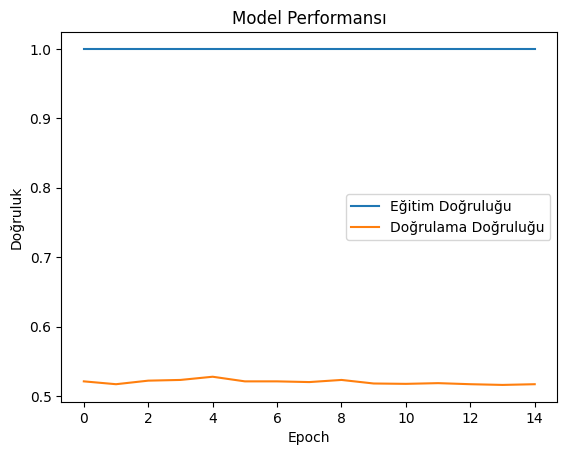

In [8]:
plt.plot(history.history['accuracy'], label='Eğitim Doğruluğu')
plt.plot(history.history['val_accuracy'], label='Doğrulama Doğruluğu')
plt.legend()
plt.title('Model Performansı')
plt.xlabel('Epoch')
plt.ylabel('Doğruluk')
plt.show()


**7.Manipülasyon Farklı Işık Koşullarında Görseller**
cv2.convertScaleAbs:
alpha: Kontrastı artırır (varsayılan = 1.0).
beta: Parlaklık değeri ekler.
Bu işlemler, modelin farklı ışık koşullarındaki doğruluğunu test etmek için kullanılır.

In [9]:
# Görüntü manipülasyonu (örneğin parlaklık artırma)
def manipulate_images(images):
    manipulated_images = []
    for img in images:
        # Görsellerin parlaklık ve kontrastını değiştirme
        manipulated = cv2.convertScaleAbs(img, alpha=1.5, beta=30)  # alpha: kontrast, beta: parlaklık
        manipulated_images.append(manipulated)
    return np.array(manipulated_images)

# Test setine manipülasyon uygula
X_test_manipulated = manipulate_images(X_test)

print("Manipüle edilmiş test seti oluşturuldu.")



Manipüle edilmiş test seti oluşturuldu.


**8.Manipüle Edilmiş Test Seti İle Modelin Test Edilmesi**

* Bu kod, manipüle edilmiş test setindeki model doğruluğunu hesaplar.Model, farklı ışık manipülasyonlarına ne kadar dayanıklı olduğunu gösterir.


In [10]:
# Manipüle edilmiş test setinde model performansını değerlendirme
manipulated_loss, manipulated_accuracy = model.evaluate(X_test_manipulated, y_test)
print(f"Manipüle Edilmiş Test Doğruluğu: {manipulated_accuracy * 100:.2f}%")


61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.1059 - loss: 526.8643
Manipüle Edilmiş Test Doğruluğu: 10.36%


**9.Renk Sabitliği Algoritması Uygulanması**


* Gray World Algoritması: Görseldeki her renk kanalını normalize ederek, renk tonunu düzeltir.
* Renk sabitliği algoritması, farklı ışık manipülasyonlarından kaynaklanan renk kaymalarını azaltmayı hedefler.


In [11]:
# Gray World algoritması uygulama
def gray_world(images):
    wb_images = []
    for img in images:
        # Her renk kanalının ortalama değerini hesapla
        avg_b = np.mean(img[:, :, 0])
        avg_g = np.mean(img[:, :, 1])
        avg_r = np.mean(img[:, :, 2])
        avg_gray = (avg_b + avg_g + avg_r) / 3

        # Kanalları normalize et
        img[:, :, 0] = img[:, :, 0] * (avg_gray / avg_b)
        img[:, :, 1] = img[:, :, 1] * (avg_gray / avg_g)
        img[:, :, 2] = img[:, :, 2] * (avg_gray / avg_r)
        wb_images.append(img)
    return np.array(wb_images)

# Manipüle edilmiş test setine renk sabitliği uygula
X_test_corrected = gray_world(X_test_manipulated)

print("Renk sabitliği uygulanmış test seti oluşturuldu.")


Renk sabitliği uygulanmış test seti oluşturuldu.


**10. Renk Sabiti Uygulanmış Test Seti İle Modelin Test Edilmesi**
    
* Bu kod, renk sabitliği algoritması uygulanmış görseller üzerindeki model doğruluğunu hesaplar.

In [12]:
# Renk sabitliği uygulanmış test setinde modeli değerlendir
corrected_loss, corrected_accuracy = model.evaluate(X_test_corrected, y_test)
print(f"Renk Sabitliği Uygulanmış Test Doğruluğu: {corrected_accuracy * 100:.2f}%")


61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.1059 - loss: 507.2327
Renk Sabitliği Uygulanmış Test Doğruluğu: 10.36%


**11.Orijinal,Manipüle Ve Renk Sabitliği Sonuçlarının Karşılaştırılması**

In [13]:
# Orijinal test setinde doğruluk hesaplama
original_loss, original_accuracy = model.evaluate(X_test, y_test, verbose=0)

# Manipüle edilmiş test setinde doğruluk hesaplama
manipulated_loss, manipulated_accuracy = model.evaluate(X_test_manipulated, y_test, verbose=0)

# Renk sabitliği uygulanmış test setinde doğruluk hesaplama
corrected_loss, corrected_accuracy = model.evaluate(X_test_corrected, y_test, verbose=0)

# Sonuçların karşılaştırılması
print(f"Orijinal Test Doğruluğu: {original_accuracy * 100:.2f}%")
print(f"Manipüle Edilmiş Test Doğruluğu: {manipulated_accuracy * 100:.2f}%")
print(f"Renk Sabitliği Uygulanmış Test Doğruluğu: {corrected_accuracy * 100:.2f}%")


Orijinal Test Doğruluğu: 51.69%
Manipüle Edilmiş Test Doğruluğu: 10.36%
Renk Sabitliği Uygulanmış Test Doğruluğu: 10.36%


**12. Sonuçların Görselleştirilmesi**

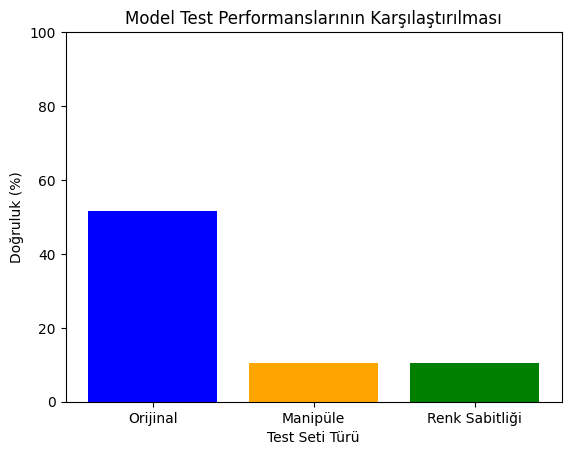

In [14]:
# Sonuçları görselleştir
import matplotlib.pyplot as plt

categories = ['Orijinal', 'Manipüle', 'Renk Sabitliği']
accuracies = [original_accuracy * 100, manipulated_accuracy * 100, corrected_accuracy * 100]

plt.bar(categories, accuracies, color=['blue', 'orange', 'green'])
plt.title("Model Test Performanslarının Karşılaştırılması")
plt.xlabel("Test Seti Türü")
plt.ylabel("Doğruluk (%)")
plt.ylim(0, 100)
plt.show()
